### مدل سه ورودی (تلاش سوم)

##### وارد کردن کتابخانه های ضروری

In [249]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##### وارد کردن دیتاست بعنوان دیتافریم پانداس

In [251]:
df = pd.read_csv('D:/AIjourney/DataSets/Roshd Center/cleaned_dataset.csv')
#df.shape

##### ایجاد تغییرات در داده های ولتاژ

In [253]:
df['Power-Prop V_smoothed'] = df['Power-Prop V'].rolling(window=300, center=True).mean()
df['Power-Prop V_smoothed'].fillna(df['Power-Prop V'], inplace=True)
df['Power-Prop V_smoothed'] = df['Power-Prop V_smoothed'] + np.random.normal(0, 0.0001, size=len(df))

C:\Users\Kiarash\AppData\Local\Temp\ipykernel_2256\48536925.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Power-Prop V_smoothed'].fillna(df['Power-Prop V'], inplace=True)


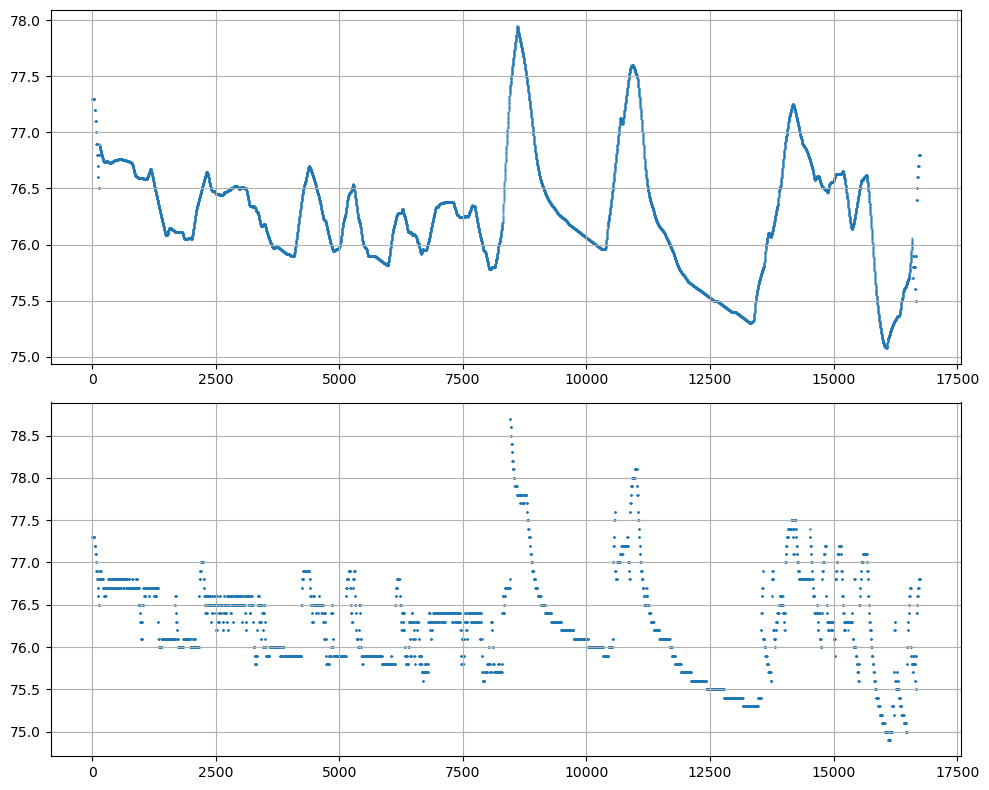

In [254]:
timeLine = np.arange(0,16744,1)

fig, axe = plt.subplots(nrows=2, ncols=1,figsize=(10,8))

axe[0].scatter(timeLine, df['Power-Prop V_smoothed'],s=0.1)
axe[0].grid(True)

axe[1].scatter(timeLine, df['Power-Prop V'],s=0.1)
axe[1].grid(True)

plt.tight_layout()
#plt.savefig("D:/AIjourney/newPics/Phase3/Attempt 3/voltageComp3_window400.png", format="png", dpi=300)
plt.show()

##### جداسازی داده های ورودی و خروجی

In [256]:
X = df[['Power-Prop V_smoothed', 'Depth1', 'Motor-FB']]  # (ولتاژ تغییر یافته)سه ورودی
Y = df[['Power-Prop I']]   # یک خروجی

#### مقیاس بندی داده ها و تقسیم بندی

##### ایجاد شی مقیاس ساز

In [259]:
inputScaler = RobustScaler()
outputScaler = RobustScaler()

##### تنظیم مقیاس ساز ها و مقیاس بندی داده(نرمالسازی داده ها)

In [261]:
X_norm = inputScaler.fit_transform(X)
Y_norm = outputScaler.fit_transform(Y)

##### جداسازی و تقسیم بندی داده های تمرین و تست

In [263]:
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=42)

### ایجاد شبکه عصبی و تمرین دادن مدل

##### وارد کردن کتابخانه ها

In [266]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

##### ساختن شی و ایجاد شبکه عصبی با تابع

In [268]:
def create_model():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))  

    layer_1 = layers.Dense(128, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001))(inputs)
    layer_1 = layers.Dropout(0.3)(layer_1)  # Dropout for regularization

    layer_2 = layers.Dense(64, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001))(layer_1)
    layer_2 = layers.Dropout(0.3)(layer_2)

    layer_3 = layers.Dense(32, activation="leaky_relu")(layer_2)

    output = layers.Dense(1, name='current_output')(layer_3)

    model = models.Model(inputs=inputs, outputs=output)
    return model

model_NN = create_model()

model_NN.compile(optimizer=AdamW(learning_rate=0.001),
              loss="mse",
              metrics=["mse"])

##### اضافه کردن توقف زودهنگام و تنظیم کننده نرخ یادگیری

In [270]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

##### تمرین دادن مدل

In [272]:
history = model_NN.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1979 - mse: 0.1164 - val_loss: 0.0924 - val_mse: 0.0364 - learning_rate: 0.0010
Epoch 2/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0930 - mse: 0.0433 - val_loss: 0.0640 - val_mse: 0.0296 - learning_rate: 0.0010
Epoch 3/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0668 - mse: 0.0360 - val_loss: 0.0488 - val_mse: 0.0266 - learning_rate: 0.0010
Epoch 4/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0516 - mse: 0.0313 - val_loss: 0.0417 - val_mse: 0.0264 - learning_rate: 0.0010
Epoch 5/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0458 - mse: 0.0317 - val_loss: 0.0350 - val_mse: 0.0237 - learning_rate: 0.0010
Epoch 6/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0397 - mse: 0.0292 - val_loss: 0.0319 - val_mse: 0.0230 - learning_rate: 0.0010
Epoch 7/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0356 - mse: 0.0272 - val_loss: 0.0305 - val_mse: 0.0231 - learning_rate: 0.001

##### خلاصه اطلاعات شبکه عصبی ایجاد شده

In [274]:
model_NN.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ current_output (Dense)          │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,645 (127.52 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,764 (85.02 KB)

##### بررسی نمودار تابع زیان در مراحل تمرین دادن مدل

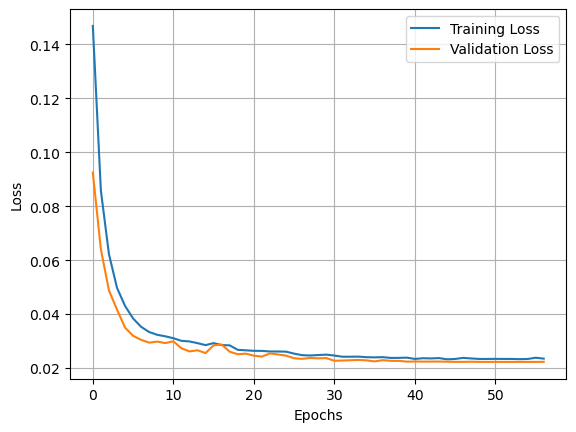

In [276]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
#plt.savefig("D:/AIjourney/newPics/Phase3/Attempt 3/Plots/lossPlot.png", format="png", dpi=300)
plt.show()

##### ارزیابی عملکرد و دقت مدل در پیشبینی

In [278]:
from sklearn.metrics import r2_score

##### ارزیابی با داده تست

In [280]:
prediction1 = model_NN.predict(X_test)
evalCurrent = r2_score(Y_test, prediction1)

print('Current prediction accuracy:',evalCurrent)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Current prediction accuracy: 0.9401710406791182


##### ارزیابی با کل دیتاست

In [282]:
predTotal = model_NN.predict(X_norm)
evalCurrentTotal = r2_score(Y_norm, predTotal)

print('Current prediction accuracy(whole dataset):',evalCurrentTotal)

524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Current prediction accuracy(whole dataset): 0.9480315376164286


##### نمودار جریان واقعی و پیشبینی شده در دیتاست اصلی

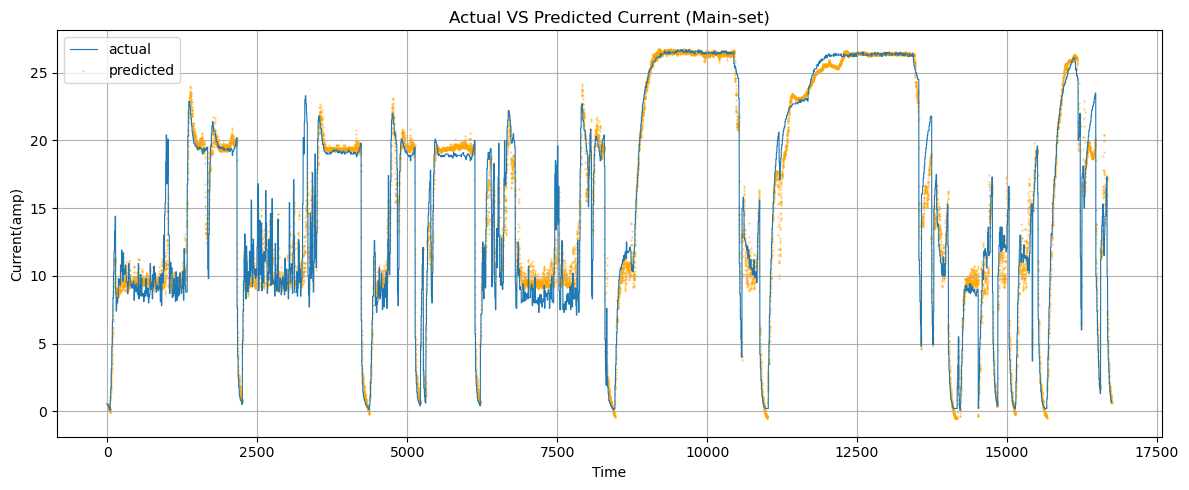

In [284]:
deNormPred = outputScaler.inverse_transform(predTotal)
timeLine = np.arange(0, 16744, 1)

plt.figure(figsize=(12,5))
plt.plot(timeLine, df['Power-Prop I'],label="actual", linewidth=0.8)
plt.scatter(timeLine, deNormPred,alpha=0.7,s=0.2,label="predicted", color="orange")
plt.title('Actual VS Predicted Current (Main-set)')
plt.ylabel('Current(amp)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("D:/AIjourney/newPics/Phase3/Attempt 3/Plots/currentMainSet.png", format="png", dpi=300)
plt.show()

### ارزیابی مدل با دیتاست ثانویه

##### وارد کردن دیتاست های ثانویه

In [287]:
dfTest1 = pd.read_csv('D:/AIjourney/DataSets/Roshd Center/CleanedTest1.csv')
dfTest2 = pd.read_csv('D:/AIjourney/DataSets/Roshd Center/CleanedTest2.csv')
dfTest3 = pd.read_csv('D:/AIjourney/DataSets/Roshd Center/CleanedTest3.csv')

##### جداسازی ورودی و خروجی بر روی دیتاست ها

In [289]:
test1_X = np.array(dfTest1[['Power-Prop V', 'Depth1', 'Motor-FB']])
test1_Y = dfTest1[['Power-Prop I']]

test2_X = np.array(dfTest2[['Power-Prop V', 'Depth1', 'Motor-FB']])
test2_Y = dfTest2[['Power-Prop I']]

test3_X = np.array(dfTest3[['Power-Prop V', 'Depth1', 'Motor-FB']])
test3_Y = dfTest3[['Power-Prop I']]

##### مقیاس بندی (نرمالسازی) ورودی های دیتاست های ثانویه با استفاده از مقیاس سازهای قبلی

In [291]:
test1_X_norm = inputScaler.transform(test1_X)
test2_X_norm = inputScaler.transform(test2_X)
test3_X_norm = inputScaler.transform(test3_X)

#test1_Y_norm = outputScaler.transform(test1_Y)
#test2_Y_norm = outputScaler.transform(test2_Y)
#test3_Y_norm = outputScaler.transform(test3_Y)

D:\AIjourney\programs\AnacondaFiles\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
D:\AIjourney\programs\AnacondaFiles\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
D:\AIjourney\programs\AnacondaFiles\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


##### پیشبینی مقادیر جریان با استفاده از ورودی ها

In [293]:
predTest1 = model_NN.predict(test1_X_norm)
predTest2 = model_NN.predict(test2_X_norm)
predTest3 = model_NN.predict(test3_X_norm)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


##### لغو مقیاس بندی و تبدیل معکوس داده های پیشبینی شده توسط مدل

In [295]:
predTest1_deNorm = outputScaler.inverse_transform(predTest1)
predTest2_deNorm = outputScaler.inverse_transform(predTest2)
predTest3_deNorm = outputScaler.inverse_transform(predTest3)

##### محاسبه و ارزیابی دقت پیشبینی بر روی هر سه دیتاست ثانویه

In [297]:
print('Current accuracy test1:',r2_score(test1_Y['Power-Prop I'], predTest1_deNorm))
print('\n')
print('Current accuracy test2:',r2_score(test2_Y['Power-Prop I'], predTest2_deNorm))
print('\n')
print('Current accuracy test3:',r2_score(test3_Y['Power-Prop I'], predTest3_deNorm))

Current accuracy test1: 0.9311883351997174


Current accuracy test2: 0.9272663695111679


Current accuracy test3: 0.959105746913222


##### مصورسازی جریان واقعی و تخمین زده شده توسط مدل

###### تغییر نوع داده خروجی دیتاست ها به آرایه چند بعدی برای استفاده در مصورسازی

In [300]:
test1_Ynp = np.array(test1_Y)
test2_Ynp = np.array(test2_Y)
test3_Ynp = np.array(test3_Y)

##### تولید نمودار به ازای هر دیتاست ثانویه

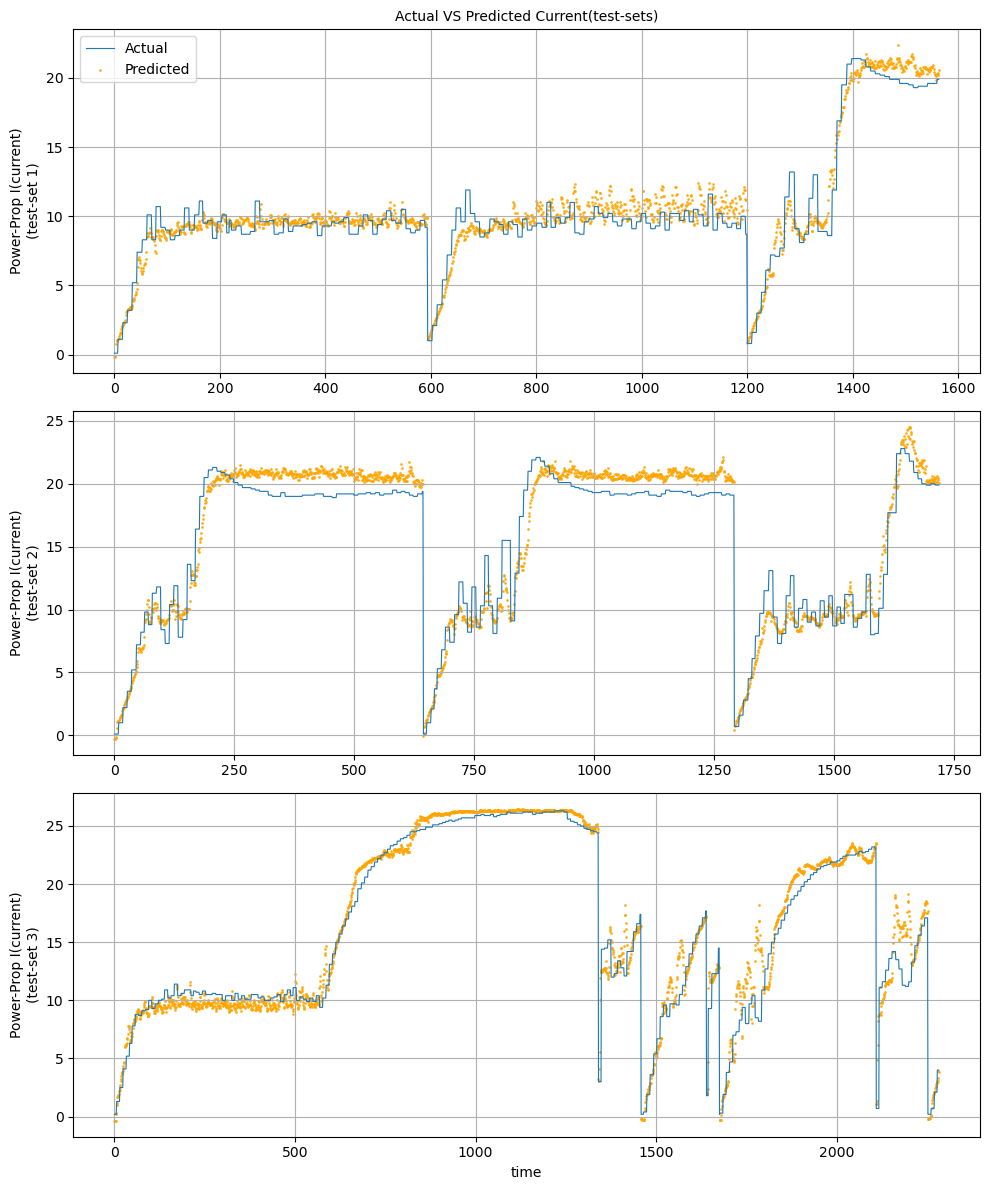

In [353]:
time1 = np.arange(0,1564,1)
time2 = np.arange(0,1719,1)
time3 = np.arange(0,2283,1)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].plot(time1,test1_Ynp,linewidth=0.8, label='Actual')
axes[0].scatter(time1,predTest1_deNorm,alpha=0.8,s=1,label='Predicted',color='orange')
axes[0].set_ylabel('Power-Prop I(current)\n(test-set 1)',fontsize=10)
axes[0].set_title('Actual VS Predicted Current(test-sets)',fontsize=10)
axes[0].grid(True)

axes[1].plot(time2,test2_Ynp,linewidth=0.8)
axes[1].scatter(time2,predTest2_deNorm,alpha=0.8,s=1,color='orange')
axes[1].set_ylabel('Power-Prop I(current)\n(test-set 2)',fontsize=10)
axes[1].grid(True)


axes[2].plot(time3,test3_Ynp,linewidth=0.8)
axes[2].scatter(time3,predTest3_deNorm,alpha=0.8,s=1,color='orange')
axes[2].set_ylabel('Power-Prop I(current)\n(test-set 3)',fontsize=10)
axes[2].set_xlabel('time',fontsize=10)
axes[2].grid(True)


plt.tight_layout()
axes[0].legend()
#plt.savefig("D:/AIjourney/newPics/Phase3/Attempt 3/currentTestSet1.png", format="png", dpi=300)
plt.show()

#### ذخیره سازی مدل و مقیاس سازها

In [304]:
import joblib

##### ذخیره کردن مقیاس سازها

In [345]:
joblib.dump(inputScaler, "D:/AIjourney/NN_Models/Phase3/Attempt 3_2/scalers/inputScaler.pkl")
joblib.dump(outputScaler, "D:/AIjourney/NN_Models/Phase3/Attempt 3_2/scalers/outputScaler.pkl")

['D:/AIjourney/NN_Models/Phase3/Attempt 3_2/scalers/outputScaler.pkl']

#### ذخیره کردن شبکه عصبی

##### h5 ذخیره سازی با فرمت

In [347]:
model_NN.save("D:/AIjourney/NN_Models/Phase3/Attempt 3_2/BLDC_Neural_Network_Model.h5")

##### keras ذخیره سازی با فرمت

In [349]:
model_NN.save("D:/AIjourney/NN_Models/Phase3/Attempt 3_2/BLDC_Neural_Network_Model.keras")

##### تغییرات ایجاد شده در دیتاست

In [313]:
df.iloc[8210:8220]

,DateTime-DataName,Motor-FB,Depth1,Power-Prop V,Power-Prop I,Power-Prop V_smoothed
8210,05:20.7,752,197,75.7,18.9,75.954456
8211,05:20.8,748,198,75.7,18.9,75.957998
8212,05:21.0,747,196,75.7,18.9,75.961266
8213,05:21.1,747,195,75.7,18.9,75.964807
8214,05:21.2,743,192,75.7,18.9,75.967845
8215,05:21.3,746,192,75.8,18.5,75.971428
8216,05:21.4,740,189,75.8,18.5,75.974529
8217,05:21.5,742,185,75.8,18.5,75.977766
8218,05:21.6,738,181,75.8,18.5,75.981288
8219,05:21.7,743,178,75.8,18.5,75.984652
